Unique activity values after splitting:


array(['run', 'sit', 'walk'], dtype=object)

Label mapping: {'run': np.int64(0), 'sit': np.int64(1), 'walk': np.int64(2)}

✅ Model trained.

🔍 Accuracy: 0.8884

📄 Classification Report:
              precision    recall  f1-score   support

         run       0.81      0.87      0.84    196265
         sit       1.00      1.00      1.00    198668
        walk       0.86      0.80      0.83    198511

    accuracy                           0.89    593444
   macro avg       0.89      0.89      0.89    593444
weighted avg       0.89      0.89      0.89    593444


🧩 Confusion Matrix:
         run     sit    walk
run   170078     192   25995
sit      223  198205     240
walk   39359     195  158957


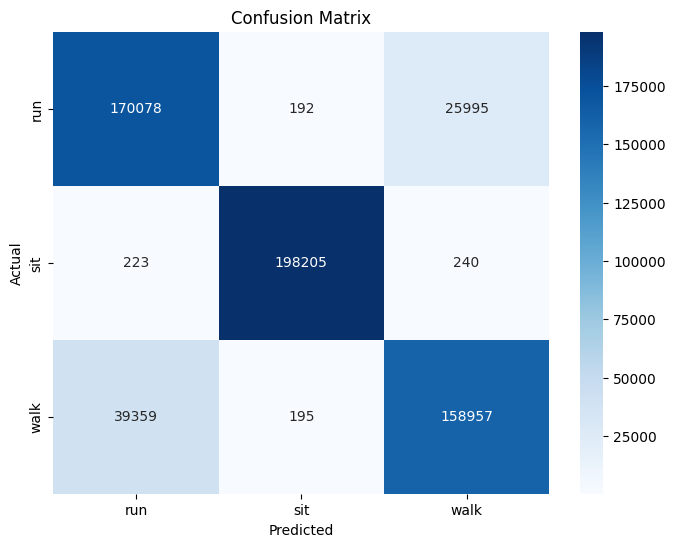

📤 Sent current activity: run (0)
🏷️ Sent dominant activity: run (0)
📤 Sent current activity: run (0)
🏷️ Sent dominant activity: run (0)
📤 Sent current activity: run (0)
🏷️ Sent dominant activity: run (0)
📤 Sent current activity: walk (2)
🏷️ Sent dominant activity: run (0)
📤 Sent current activity: run (0)
🏷️ Sent dominant activity: run (0)
📤 Sent current activity: sit (1)
🏷️ Sent dominant activity: run (0)
📤 Sent current activity: sit (1)
🏷️ Sent dominant activity: run (0)
📤 Sent current activity: run (0)
🏷️ Sent dominant activity: run (0)
📤 Sent current activity: sit (1)
🏷️ Sent dominant activity: run (0)
📤 Sent current activity: sit (1)
🏷️ Sent dominant activity: run (0)
📤 Sent current activity: walk (2)
🏷️ Sent dominant activity: run (0)
📤 Sent current activity: walk (2)
🏷️ Sent dominant activity: run (0)
📤 Sent current activity: walk (2)
🏷️ Sent dominant activity: run (0)
📤 Sent current activity: walk (2)
🏷️ Sent dominant activity: run (0)
📤 Sent current activity: run (0)
🏷️ Sent do

In [ ]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from collections import deque
import requests
import time

# Optional: for confusion matrix plot
import matplotlib.pyplot as plt
import seaborn as sns

# === CONFIG ===
DATA_DIR = "/content/csv"  # CSV directory
BLYNK_AUTH = "LYIz928b1h3F0HN_F0CnMvEZIish-OdJ"  # Blynk token

# Blynk virtual pins
PIN_NUMERIC = "1"          # Current prediction (numeric)
PIN_LABEL = "2"            # Current prediction (label)
PIN_DOMINANT_NUM = "6"     # Dominant activity (numeric)
PIN_DOMINANT_LABEL = "7"   # Dominant activity (label)

SEND_INTERVAL = 2  # seconds between updates
WINDOW_SIZE = 20   # sliding window size for dominant activity

# === Load & Clean Data ===
csv_files = [os.path.join(DATA_DIR, f) for f in os.listdir(DATA_DIR) if f.endswith('.csv')]
df_list = []

for f in csv_files:
    df = pd.read_csv(f)
    df.columns = df.columns.str.strip().str.lower()
    df.rename(columns={
        'g_x': 'gyro_x', 'g_y': 'gyro_y', 'g_z': 'gyro_z',
        'gx': 'gyro_x', 'gy': 'gyro_y', 'gz': 'gyro_z',
        'label': 'activity'
    }, inplace=True)
    if 'activity' not in df.columns:
        df['activity'] = os.path.splitext(os.path.basename(f))[0].lower()
    df_list.append(df)

data = pd.concat(df_list, ignore_index=True)

# Keep only necessary columns
data = data[['gyro_x', 'gyro_y', 'gyro_z', 'activity']].dropna()

# Filter for 'sitting', 'walking', 'running' only
data['activity'] = data['activity'].str.lower()
# Extract activity name after the underscore
data['activity'] = data['activity'].apply(lambda x: x.split('_')[-1] if '_' in x else x)

# --- Add this line to inspect activity values ---
print("Unique activity values after splitting:")
display(data['activity'].unique())
# ------------------------------------------------

allowed_activities = ['sit', 'walk', 'run'] # Corrected activity names
data = data[data['activity'].isin(allowed_activities)].copy()

# Ensure data is available
if data.empty:
    raise ValueError("No valid data found for sitting/walking/running.")

# Encode activity labels
label_encoder = LabelEncoder()
data['activity_encoded'] = label_encoder.fit_transform(data['activity'])

print("Label mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

# Prepare features and labels
X = data[['gyro_x', 'gyro_y', 'gyro_z']]
y = data['activity_encoded']

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Train model
model = RandomForestClassifier(n_estimators=200, max_depth=15, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)
print("\n✅ Model trained.")

# Evaluate model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"\n🔍 Accuracy: {accuracy:.4f}")

print("\n📄 Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=label_encoder.classes_, columns=label_encoder.classes_)
print("\n🧩 Confusion Matrix:")
print(cm_df)

# Plot confusion matrix
try:
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
except Exception as e:
    print(f"Plotting failed: {e}")

# === Blynk Sending Functions ===
def send_to_blynk(numeric_value, label_value):
    try:
        requests.get(f"https://blynk.cloud/external/api/update?token={BLYNK_AUTH}&v{PIN_NUMERIC}={numeric_value}")
        requests.get(f"https://blynk.cloud/external/api/update?token={BLYNK_AUTH}&v{PIN_LABEL}={label_value}")
        print(f"📤 Sent current activity: {label_value} ({numeric_value})")
    except Exception as e:
        print(f"❌ Error sending current activity: {e}")

def send_dominant_activity_to_blynk(numeric_value, label_value):
    try:
        requests.get(f"https://blynk.cloud/external/api/update?token={BLYNK_AUTH}&v{PIN_DOMINANT_NUM}={numeric_value}")
        requests.get(f"https://blynk.cloud/external/api/update?token={BLYNK_AUTH}&v{PIN_DOMINANT_LABEL}={label_value}")
        print(f"🏷️ Sent dominant activity: {label_value} ({numeric_value})")
    except Exception as e:
        print(f"❌ Error sending dominant activity: {e}")

# === Real-Time Prediction Simulation ===
activity_window = deque(maxlen=WINDOW_SIZE)

def simulate_and_send():
    idx = 0
    total = len(X_test)

    while True:
        sample = X_test[idx].reshape(1, -1)
        pred_encoded = model.predict(sample)[0]
        pred_label = label_encoder.inverse_transform([pred_encoded])[0]

        activity_window.append(pred_label)

        # Send current prediction
        send_to_blynk(pred_encoded, pred_label)

        # Send dominant activity in the window
        if len(activity_window) > 0:
            dominant_label = max(set(activity_window), key=activity_window.count)
            dominant_encoded = label_encoder.transform([dominant_label])[0]
            send_dominant_activity_to_blynk(dominant_encoded, dominant_label)

        idx = (idx + 1) % total
        time.sleep(SEND_INTERVAL)

# === Run ===
if __name__ == "__main__":
    simulate_and_send()